# W-ICA

In [84]:
from data_slicing.slicing import get_data
from data_slicing.metadata import metadata
import mne
import numpy as np
import importlib
from matplotlib import pyplot
import pywt

In [59]:
patient_code = "p10"
patient_metadata = metadata[patient_code]
records = patient_metadata["records"]
record = records[0]
normal_record, seizure_record, info = get_data(record)

Extracting EDF parameters from D:\workspace2\eeg-epilepsy\data\EpilepticEEGDataset\p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5401499  =      0.000 ... 10802.998 secs...
=== record_time === 2023-04-03 05:36:39
s_index, s_index_end:  3599500 3822000
=== raw_data.shape ===  (19, 5401500)
=== normal_record.shape ===  (19, 5179000)
=== seizure_record.shape ===  (19, 222500)


In [60]:
start = 0
length = 12800
used_record = normal_record
used_data = used_record[:, start:start+length]
new_info = mne.create_info(info["ch_names"], ch_types=["eeg"] * len(info["ch_names"]), sfreq=500)
raw = mne.io.RawArray(used_record[:, start:start+length], new_info)

Creating RawArray with float64 data, n_channels=19, n_times=12800
    Range : 0 ... 12799 =      0.000 ...    25.598 secs
Ready.


In [61]:
from online_system import emd_ica_artifact_removal
importlib.reload(emd_ica_artifact_removal)
ica_components, ica, ica_raw = emd_ica_artifact_removal.ICA_decompose(used_data, info["ch_names"])

Creating RawArray with float64 data, n_channels=19, n_times=12800
    Range : 0 ... 12799 =      0.000 ...    25.598 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Fitting ICA took 0.9s.


In [80]:
from wica import wt
importlib.reload(wt)
ica_components_data = ica_components.get_data()
wt_coff = wt.stationary_wt(np.array(ica_components_data[0]), level=6)

## Test Soft Thresholding

thresh: 392.38030819702084


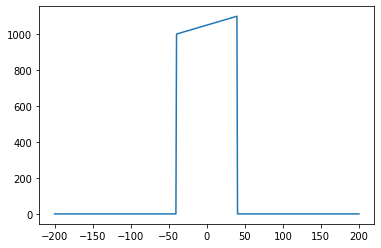

In [82]:
from wica import wt
importlib.reload(wt)
def fx(x):
    return 0
values = []
for x in range(-100, 100):
    values.append(x)
for x in range(1000, 1100):
    values.append(x)
for x in range(-100, 100):
    values.append(x)
threshed_data = wt.soft_thresholding(values)
pyplot.plot(np.linspace(-200, 200, 500), threshed_data, '-');

## Apply Soft Thresholding to WT Coefficients

In [81]:
wt_coff

[{'a': array([-0.70529288, -0.70304396, -0.70086735, ..., -0.71250242,
         -0.71002023, -0.70761761]),
  'd': array([-1.29283427, -1.22784058, -1.15578434, ..., -1.43413568,
         -1.3971632 , -1.34967834])},
 {'a': array([-0.53026983, -0.52968779, -0.52903156, ..., -0.53090396,
         -0.53092395, -0.53069857]),
  'd': array([-2.86759594, -2.61696526, -2.31921409, ..., -3.21050146,
         -3.17654069, -3.05837095])},
 {'a': array([-0.30447457, -0.28163157, -0.25791071, ..., -0.36647304,
         -0.34717136, -0.32642236]),
  'd': array([-2.89124191, -2.16830647, -1.42520677, ..., -3.93019736,
         -3.89080394, -3.50574635])},
 {'a': array([-0.22020472, -0.17276216, -0.13514098, ..., -0.32549952,
         -0.29859309, -0.26323218]),
  'd': array([-0.45987489,  0.64939597,  1.00619952, ..., -5.18052348,
         -4.18947229, -2.29345595])},
 {'a': array([ 0.05855939, -0.12918875, -0.47014476, ..., -0.19734205,
         -0.09166565,  0.0381841 ]),
  'd': array([ 1.1648202

In [83]:
threshed_wt_coff = []
for level_coff in wt_coff:
    threshed_wt_coff.append({
        'a': wt.soft_thresholding(level_coff['a']),
        'd': wt.soft_thresholding(level_coff['d'])
    })
threshed_wt_coff

thresh: 8.104899589973021
thresh: 1.252008492476781
thresh: 5.81485032170753
thresh: 0.49034873580428184
thresh: 4.125866774804272
thresh: 0.22343313195208442
thresh: 2.9090121900406567
thresh: 0.07950028013444878
thresh: 2.0553659551624817
thresh: 0.022068076261781647
thresh: 1.4515929062320314
thresh: 0.006810853778573693


[{'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-1.29283427,  0.        ,  0.        , ..., -1.43413568,
         -1.3971632 , -1.34967834])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-2.86759594, -2.61696526, -2.31921409, ..., -3.21050146,
         -3.17654069, -3.05837095])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-2.89124191, -2.16830647, -1.42520677, ..., -3.93019736,
         -3.89080394, -3.50574635])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-0.45987489,  0.64939597,  1.00619952, ..., -5.18052348,
         -4.18947229, -2.29345595])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([ 1.16482022,  1.01902443,  0.66229317, ..., -5.69563167,
         -1.54830891,  0.96069606])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-0.19359098, -0.41069197,  0.01298462, ..., -3.00060831,
          0.99092841,  1.04579654])}]

## Inverse WT

In [88]:
artifact_component = pywt.iswtn(threshed_wt_coff, 'coif5')

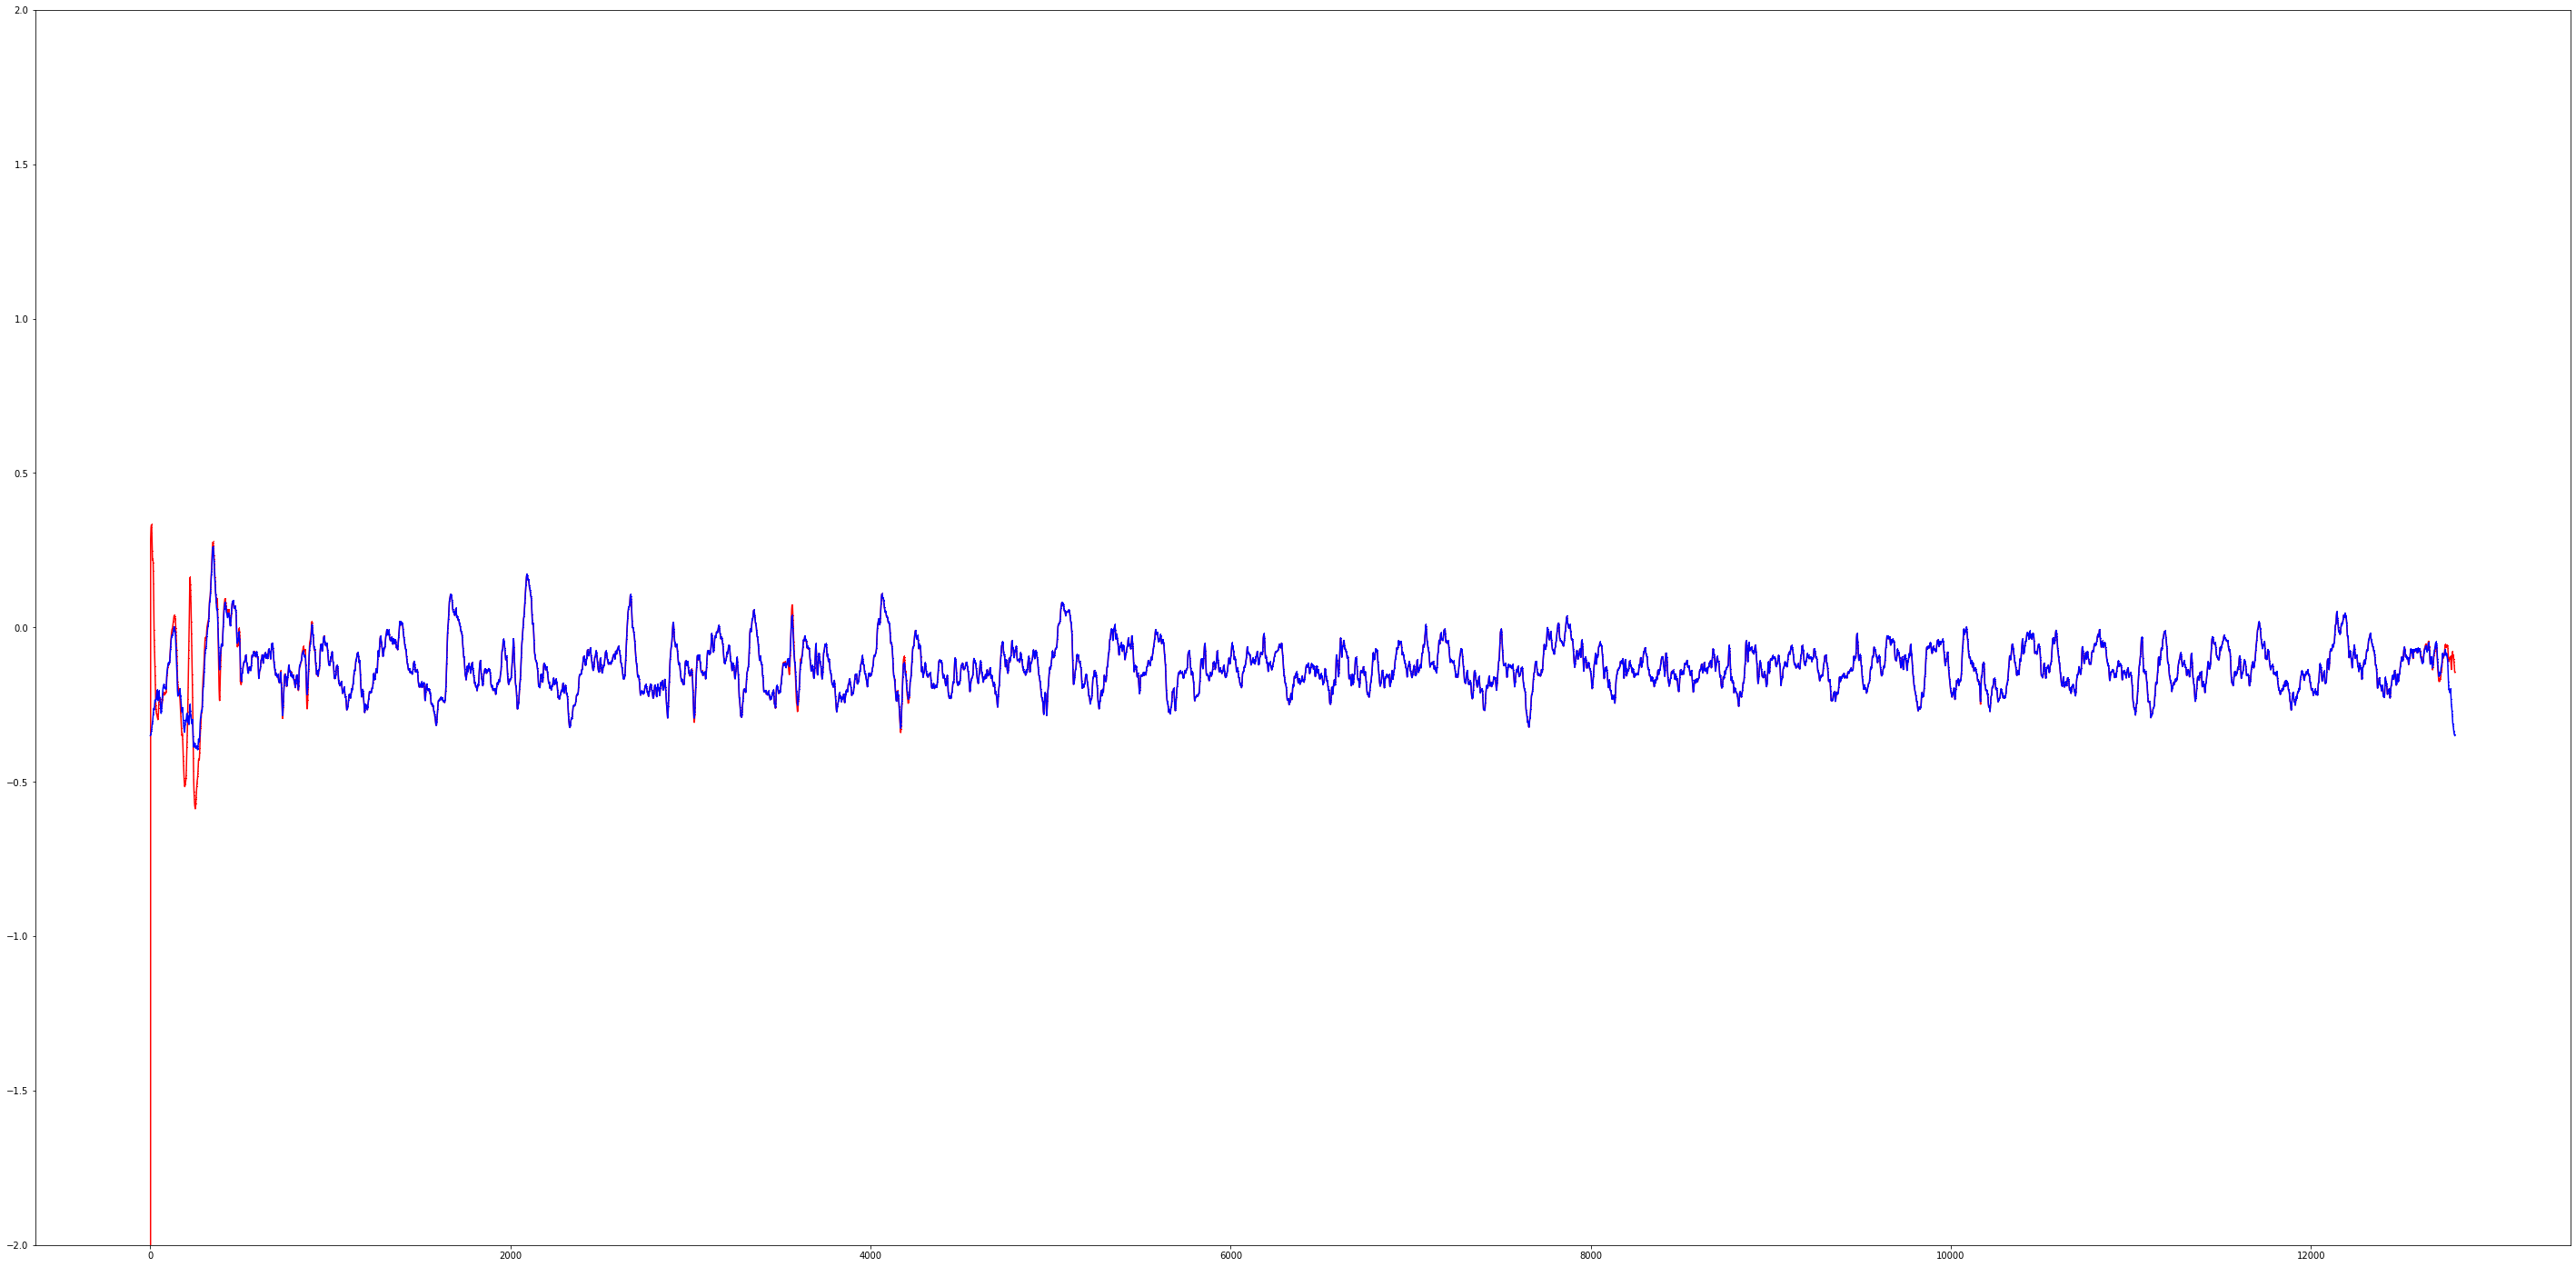

In [101]:
figure1 = pyplot.figure(0, (50, 25))
pyplot.ylim(-2, 2)
component_without_artifact = ica_components_data[0] - np.array(artifact_component)
pyplot.plot(np.linspace(0, len(ica_components_data[0]), len(ica_components_data[0])), ica_components_data[0], ',-', color ='r')
pyplot.plot(np.linspace(0, len(component_without_artifact), len(component_without_artifact)), component_without_artifact, ',-', color ='b')